<a href="https://colab.research.google.com/github/Nohalyan/Projetppchem/blob/Enzo/Notebook_WSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Water Solubility Predisction



## 1.1 Import Relevant Modules and Libraries

Let's first start by importing relevant modules and libraries needed for this project.


In [3]:
# Install all libraries
!pip install pathlib numpy pandas rdkit matplotlib scikit-learn lightgbm lazypredict tqdm xgboost

In [4]:
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

import numpy as np

import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

from lightgbm import LGBMRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer


# lazypredict helps to train 42 ML models with a single line of code ans find the best ML models
import lazypredict
from lazypredict.Supervised import LazyRegressor

from tqdm import tqdm

import pickle


# 2.1 Let's get the Solubility Data

First, we will get solubility data from gashawmg (source: https://github.com/gashawmg) and perform exploratory data analysis

In [5]:
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data_Solubility.csv

--2024-04-29 12:35:33--  https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data_Solubility.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 987356 (964K) [text/plain]
Saving to: ‘Data_Solubility.csv.1’

Data_Solubility.csv 100%[===================>] 964.21K  --.-KB/s    in 0.05s   

2024-04-29 12:35:33 (20.0 MB/s) - ‘Data_Solubility.csv.1’ saved [987356/987356]



Let's open the file

In [6]:
# Create a Path object for the current directory, in our case /content/
current_directory = Path.cwd()
print("Current Directory:", current_directory.resolve())

file_path = current_directory / "Data_Solubility.csv"

# Reading the contents of the file and check that the file exists
if file_path.exists():
    with file_path.open("r") as file:
        content = file.read()
#       print(content)
else:
    print("The file does not exist.")


Current Directory: /content


The file use semicicolon as delimiter, so let's open the file and use semicicolon as delimiter:

In [7]:
# open a file containing descriptors and yield
data_solubility = pd.read_csv("/content/Data_Solubility.csv", delimiter=';')

Check the data see if it is what we want

In [8]:
data_solubility.shape

(9943, 6)

In [9]:
data_solubility.head()

,Compound ID,InChIKey,SMILES,logS,logP,MW
0,C1711,ACTIUHUUMQJHFO-UPTCCGCDSA-N,COC1=C(OC)C(=O)C(=C(C1=O)C/C=C(/CC/C=C(/CC/C=C...,-18.22,17.85,863.34
1,C1712,CQISYTXUORWJSX-UHFFFAOYSA-N,CCCCCCCCCCCCCCCCCC(=O)Nc1ccc(cc1)NC(=O)CCCCCCC...,-17.47,14.23,641.07
2,C1713,UXPYIAWFQKSHNV-UHFFFAOYSA-N,CCCCCCCCCCCCCCCC(=O)OCCCCOC(=O)CCCCCCCCCCCCCCC,-16.26,11.82,566.94
3,C1714,BDIWFCKBPZPBQT-UHFFFAOYSA-N,CCCC[Sn](S[Sn](CCCC)(CCCC)CCCC)(CCCC)CCCC,-15.68,10.41,612.15
4,C1715,RNPXCFINMKSQPQ-UHFFFAOYSA-N,CCCCCCCCCCCCCCCCOP(=O)(OCCCCCCCCCCCCCCCC)O,-15.21,12.08,546.85


Looks nice to me!

#2.2 Data Cleaning
## 2.2.1 Remove NaN or null values

We wil start by removing non-numerical values and valeurs that are null:

In [10]:
data_solubility.SMILES.isnull().sum()
data_solubility.dropna(inplace=True)
data_solubility.shape

(9943, 6)

As we can see, the shape is still the same, the data has already been cleaned of non-numerical and null values.
##2.2.2 Remove outliers

Then, we will remove outliers from the data. Using a boxplot, we can easely visualize outliers:


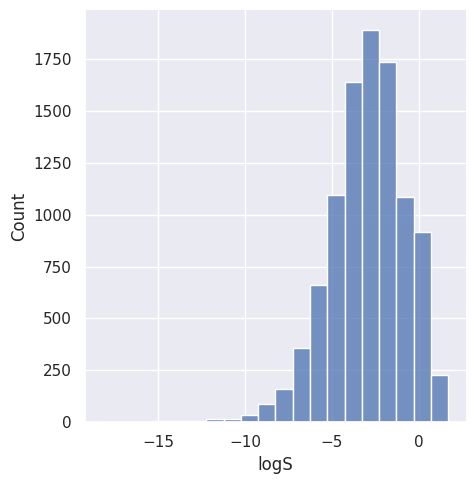

In [11]:
sn.set_theme()
sn.displot(data=data_solubility, x="logS", binwidth=1)

Let's filter compounds that follow as close as normal distribution, let's say between -7.5 and 1.7:


In [12]:
new_data_solubility = data_solubility[data_solubility.logS.apply(lambda x: x > -7.5 and x < 1.7)]

Let's generate an histogram to see the new data:

(9648, 6)

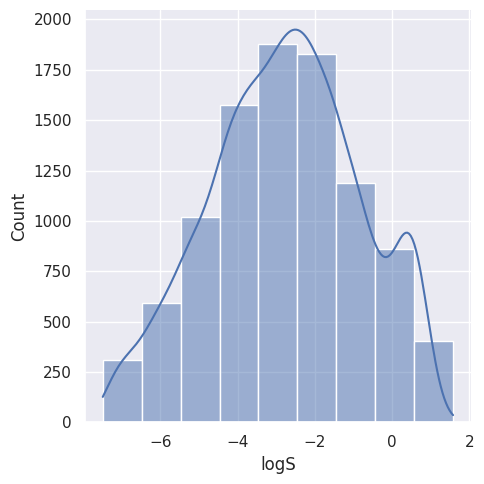

In [13]:
sn.displot(data=new_data_solubility, x='logS', binwidth=1,kde=True)
new_data_solubility.shape

##2.2.3 Remove Duplicates

Then remove duplicate by generating canonical SMILES:

In [14]:
# generate a canonical SMILES function
def canonical_SMILES(smiles):
    canon_smls = [Chem.CanonSmiles(smls) for smls in smiles]
    return canon_smls

In [15]:
# Generate canonical Smiles using the function
canon_smiles = canonical_SMILES(new_data_solubility.SMILES)

# Replace SMILES column with canonical SMILES
new_data_solubility["SMILES"] = canon_smiles

# Create a list for duplicate smiles
duplicate_smiles = new_data_solubility[new_data_solubility['SMILES'].duplicated()]['SMILES'].values
len(duplicate_smiles)

6

As we can see, their are 6 duplicates, so we have to filter them and we can also sort them for better reading:

In [16]:
new_data_solubility[new_data_solubility['SMILES'].isin(duplicate_smiles)].sort_values(by=['SMILES'])

,Compound ID,InChIKey,SMILES,logS,logP,MW
5683,C1698,WUBBRNOQWQTFEX-UHFFFAOYSA-N,CC(=O)Nc1nnc(S(N)(=O)=O)s1,-2.44,1.00,222.25
5836,C943,BZKPWHYZMXOIDC-UHFFFAOYSA-N,CC(=O)Nc1nnc(S(N)(=O)=O)s1,-2.36,1.00,222.25
7282,C7745,VWPOSFSPZNDTMJ-UCWKZMIHSA-N,CC(C)(C)NCC(O)COc1cccc2c1C[C@H](O)[C@H](O)C2,-1.57,1.03,309.40
8063,C1707,IWVCMVBTMGNXQD-PXOLEDIWSA-N,CC(C)(C)NCC(O)COc1cccc2c1C[C@H](O)[C@H](O)C2,-1.01,1.03,309.40
1345,C199,WKRLQDKEXYKHJB-HFTRVMKXSA-N,C[C@]12CC[C@H]3C(=CCc4cc(O)ccc43)[C@@H]1CCC2=O,-5.28,3.74,268.35
1347,C1673,WKRLQDKEXYKHJB-HFTRVMKXSA-N,C[C@]12CC[C@H]3C(=CCc4cc(O)ccc43)[C@@H]1CCC2=O,-5.28,3.74,268.35
5152,C1696,QZUDBNBUXVUHMW-UHFFFAOYSA-N,Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1,-2.70,3.10,253.28
5319,C843,JLKIGFTWXXRPMT-UHFFFAOYSA-N,Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1,-2.62,3.10,253.28
3918,C604,NXFQHRVNIOXGAQ-YCRREMRBSA-N,O=C1CN(/N=C/c2ccc([N+](=O)[O-])o2)C(=O)N1,-3.38,0.86,238.16
4159,C1690,NXFQHRVNIOXGAQ-OQFOIZHKSA-N,O=C1CN(/N=C/c2ccc([N+](=O)[O-])o2)C(=O)N1,-3.24,0.86,238.16


Let's drop rows that contain duplicate SMILES and keep the first structure:

In [17]:
data_solubility_cleaned = new_data_solubility.drop_duplicates(subset=['SMILES'], keep='first')
data_solubility_cleaned.shape
data_solubility_cleaned.head()

,Compound ID,InChIKey,SMILES,logS,logP,MW
294,C1951,NZFNXWQNBYZDAQ-UHFFFAOYSA-N,CSc1ccc2c(c1)N(CCC1CCCCN1C)c1ccccc1S2.Cl,-7.49,6.69,407.04
295,C1952,CIMQMKORBAJNEC-UHFFFAOYSA-N,CC(=O)OCCN1CCN(CCCN2c3ccccc3Sc3ccc(C(F)(F)F)cc...,-7.49,6.42,552.48
296,C1953,MOPIFNSMNXBREW-UHFFFAOYSA-N,CCCCCCCNc1c2ccccc2nc2ccccc12,-7.48,5.84,292.42
297,C1954,CKHJPWQVLKHBIH-ZDSKVHJSSA-N,C/C(=C(\CCOC(=O)C(C)C)SS/C(CCOC(=O)C(C)C)=C(/C...,-7.47,7.12,702.89
298,C1955,NAPSCFZYZVSQHF-UHFFFAOYSA-N,CCCCCCCCCCCCCCCCCCN(C)C,-7.46,6.81,297.56


## 2.2.4 Filter training data

Now that we have a dataset, let's prepapare a test stet containing 100 drug-like compounds (source: https://github.com/PatWalters/solubility)

In [18]:
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data_Drug_Like_Solubility.csv

--2024-04-29 12:36:30--  https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data_Drug_Like_Solubility.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5557 (5.4K) [text/plain]
Saving to: ‘Data_Drug_Like_Solubility.csv.1’

Data_Drug_Like_Solu 100%[===================>]   5.43K  --.-KB/s    in 0s      

2024-04-29 12:36:30 (46.3 MB/s) - ‘Data_Drug_Like_Solubility.csv.1’ saved [5557/5557]



In [19]:
# Create a Path object for the current directory, in our case /content/
current_directory_dl = Path.cwd()
print("Current Directory:", current_directory.resolve())

file_path_dl = current_directory / "Data_Drug_Like_Solubility.csv"

# Reading the contents of the file and check that the file exists
if file_path.exists():
    with file_path.open("r") as file:
        content = file.read()
#        print(content)
else:
    print("The file does not exist.")


Current Directory: /content


In [20]:
data_dl = pd.read_csv("/content/Data_Drug_Like_Solubility.csv", delimiter=';')
data_dl.shape

(100, 3)

In [21]:
data_dl.head()

,Chemical name,SMILES,LogS exp (mol/L)
0,Acetanilide,O=C(Nc1ccccc1)C,-1.40
1,Adenosine,c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3...,-1.73
2,Allopurinol,c1c2c([nH]n1)ncnc2O,-2.26
3,Trimethoprim,COc1cc(cc(c1OC)OC)Cc2cnc(nc2N)N,-2.95
4,Acetazolamide,O=S(=O)(c1nnc(s1)NC(=O)C)N,-2.44


In [22]:
# Generate canonical Smiles
canon_smiles = canonical_SMILES(data_dl.SMILES)

# Replace SMILES column wit Canonical SMILES
data_dl["SMILES"] = canon_smiles

# Create a list for duplicate smiles
duplicate_data_dl_smiles = data_dl[data_dl['SMILES'].duplicated()]['SMILES'].values
len(duplicate_data_dl_smiles)

0

In [23]:
# Molecules used in training and test of the model
data_dl_SMILES = data_dl.SMILES.values

# Filter molecules that are not present in the test set
data_cleaned_final = data_solubility_cleaned[~data_solubility_cleaned['SMILES'].isin(data_dl_SMILES)]
print(f'Compounds present in training set:{len(data_solubility_cleaned) - len(data_cleaned_final)}')
data_cleaned_final.shape

Compounds present in training set:93


(9549, 6)

In [24]:
data_dl= data_dl[data_dl['LogS exp (mol/L)'].apply(lambda x: x > -7.5 and x < 1.7)]
data_dl

,Chemical name,SMILES,LogS exp (mol/L)
0,Acetanilide,CC(=O)Nc1ccccc1,-1.40
1,Adenosine,Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O,-1.73
2,Allopurinol,Oc1ncnc2[nH]ncc12,-2.26
3,Trimethoprim,COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC,-2.95
4,Acetazolamide,CC(=O)Nc1nnc(S(N)(=O)=O)s1,-2.44
...,...,...,...
95,Sulfanilamide,Nc1ccc(S(N)(=O)=O)cc1,-1.36
96,Gliclazide,Cc1ccc(S(=O)(=O)NC(=O)NN2CC3CCCC3C2)cc1,-4.29
97,Trihexyphenidyl,OC(CCN1CCCCC1)(c1ccccc1)C1CCCCC1,-5.20
98,Triphenylene,c1ccc2c(c1)c1ccccc1c1ccccc21,-6.73


# 3. Calculation of RDkit Molecular Descriptors, which are molecular features

In [25]:
def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0]
                                    for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    Mol_descriptors =[]
    for mol in tqdm(mols):
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names

# Function call
Mol_descriptors,desc_names = RDkit_descriptors(data_cleaned_final['SMILES'])

Streaming output truncated to the last 5000 lines.
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
----------
Stacktrace:
----------
****

[12:46:39] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 40 in file /project/build/temp.linux-x86_64-cpython-310/rdkit/Code/GraphMol/Descriptors/Crippen.cpp
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
----------
Stacktrace:
----------
****

[12:46:39] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 40 in file /project/build/temp.linux-x86_64-cpython-310/rdkit/Code/GraphMol/Descriptors/Crippen.cpp
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
----------
Stacktrace:
----------
****

[12:46:39] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 40 in file /project/build/temp.linux-x86_64-cpy

In [26]:
df_descriptors = pd.DataFrame(Mol_descriptors, columns=desc_names)
df_descriptors.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,9.25,9.25,0.05,-4.68,0.55,46.96,407.05,379.83,406.13,140,...,1,0,0,0,0,0,0,0,0,0
1,14.36,14.36,0.00,-5.72,0.41,36.20,552.49,522.25,551.14,194,...,0,0,0,0,0,0,0,0,0,0
2,8.72,8.72,0.55,-4.55,0.44,31.45,292.43,268.23,292.19,114,...,0,0,0,0,0,0,0,0,0,0
3,13.83,13.83,0.86,-5.29,0.12,30.50,702.90,656.54,702.30,262,...,0,0,0,0,0,0,0,0,0,0
4,8.30,8.30,1.26,-5.38,0.27,55.19,297.57,254.23,297.34,128,...,0,0,0,0,0,0,0,0,0,0


In [27]:
df_descriptors.shape

(9549, 210)

# 4. Split the chemicals for training and validation set

In [28]:
x_train, x_valid, y_train, y_valid = train_test_split(df_descriptors, data_cleaned_final.logS, test_size=0.1,random_state=42)

#Standardization of the features

custom_scaler = StandardScaler()
custom_scaler.fit(x_train)
x_train_scaled = custom_scaler.transform(x_train)
x_valid_scaled = custom_scaler.transform(x_valid)

#5. Select Machine Learning Models

Let's selct the best ML models for that. To do that, we will use the lazypredict librarie, in particular the LazyRegressor function to test 42 ML models:

In [29]:
lregs = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None,random_state=42)
models, prediction_tests = lregs.fit(x_train_scaled, x_valid_scaled, y_train, y_valid)

 98%|█████████▊| 41/42 [05:43<00:04,  4.39s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20819
[LightGBM] [Info] Number of data points in the train set: 8594, number of used features: 188
[LightGBM] [Info] Start training from score -2.762630


100%|██████████| 42/42 [05:45<00:00,  8.22s/it]


In [30]:
#The top three models
prediction_tests[:5]

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
HistGradientBoostingRegressor,0.82,0.86,0.74,3.49
LGBMRegressor,0.81,0.85,0.75,2.07
ExtraTreesRegressor,0.80,0.84,0.77,30.84
XGBRegressor,0.79,0.84,0.78,2.93
RandomForestRegressor,0.79,0.84,0.78,69.68


# 6. Fine-tuning

# *6.1* LGBMRegressor

We decided to take the LGBMRegressor model because the results generated by this model are comparable to the ExtraTreesRegressor model, but takes a lot less time than the extra-trees model.Let's performs a grid search using GridSearchCV from scikit-learn to find the best hyperparameters for a LightGBM regressor:

In [ ]:
#params = {'max_depth' : list(range(2, 32, 8)),
#          'n_estimators' : list(range(1, 1000, 100)),
#          'learning_rate' : list(np.arange(0.01, 1.02, 0.25))}
#
#grid_search = GridSearchCV(LGBMRegressor(random_state = 42),
#                            param_grid=params, cv=5, verbose=1)
#
#grid_search.fit(x_train, y_train)
#
#print("Optimized parameters for a LightGBM regressor can be: ", grid_search.best_params_)

We obtained:
* learning_rate: 0.01
* max_depth: 26
* n_estmitors: 901

Let's optimize again with new ranges for liste max_depth, n_estmitors and learning_rate to obtain even better parameters:


In [ ]:
#params_bst = {"max_depth" : list(range(20, 36, 4)),
#         "n_estimators" : list(range(850, 1200, 50)),
#         "learning_rate" : list(np.arange(0.01, 0.05, 0.01))}
#
#grid_search_bst = GridSearchCV(LGBMRegressor(random_state = 42),
#                                  param_grid=params_bst, cv=3, verbose=1)
#
#grid_search_bst.fit(x_train, y_train)
#print("The best parameters are: ", grid_search_bst.best_params_)

# *6.2* RandomForestRegressor

To have a second regressor model we choose Random Forest for his performance in term of R, but it take a longest time to run, so we want to see his performance after tuning and see the difference

In [ ]:
# Handle missing values in x_train
#imputer = SimpleImputer(strategy='mean')
#x_train_imputed = imputer.fit_transform(x_train)

# Scale the input data
#scaler = StandardScaler()
#x_train_scaled = scaler.fit_transform(x_train_imputed)

# Define the parameter grid for grid search
#paramsRF = {
#    'max_depth': list(range(2, 32, 16)),
#    'n_estimators': list(range(1, 1000, 200))
#}

# Perform grid search with RandomForestRegressor
#grid_searchRF = GridSearchCV(RandomForestRegressor(random_state=42),
#                             param_grid=paramsRF, cv=5, verbose=1)

# Fit the grid search to the scaled data
#grid_searchRF.fit(x_train_scaled, y_train)

# Print the best parameters found
#print("Optimized parameters for a RandomForestRegressor can be: ", grid_searchRF.best_params_)



Fitting 5 folds for each of 10 candidates, totalling 50 fits
Optimized parameters for a RandomForestRegressor can be:  {'max_depth': 18, 'n_estimators': 801}


The next values are acquired:

. max depth = 18

. n_esimators = 801

In [ ]:
# Handle missing values in x_train
#imputer = SimpleImputer(strategy='mean')
#x_train_imputed = imputer.fit_transform(x_train)

# Scale the input data
#scaler = StandardScaler()
#x_train_scaled = scaler.fit_transform(x_train_imputed)

# Define the parameter grid for grid search
#paramsRF = {
#    'max_depth': list(range(2, 32, 12)),
#    'n_estimators': list(range(1, 1000, 150))
#}

# Perform grid search with RandomForestRegressor
#grid_searchRF = GridSearchCV(RandomForestRegressor(random_state=42),
#                             param_grid=paramsRF, cv=5, verbose=1)

# Fit the grid search to the scaled data
#grid_searchRF.fit(x_train_scaled, y_train)

# Print the best parameters found
#print("Optimized parameters for a RandomForestRegressor can be: ", grid_searchRF.best_params_)



Fitting 5 folds for each of 21 candidates, totalling 105 fits
Optimized parameters for a RandomForestRegressor can be:  {'max_depth': 26, 'n_estimators': 901}


Values acquired

. max_depth = 26

. n_estimators = 901

#6.3 XGBRegresssor


In [31]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Assuming x_train and y_train are already defined

# Define the parameter grid
params = {'max_depth': list(range(2, 32, 8)),
          'n_estimators': list(range(1, 201, 20)),
          'learning_rate': list(np.arange(0.01, 1.02, 0.25))}

# Create GridSearchCV object
grid_search = GridSearchCV(XGBRegressor(random_state=42),
                           param_grid=params, cv=5, verbose=1)

# Fit the grid search
grid_search.fit(x_train, y_train)

# Print the best parameters found
print("Optimized parameters for an XGBoost regressor can be:", grid_search.best_params_)



Fitting 5 folds for each of 200 candidates, totalling 1000 fits


ValueError: 
All the 1000 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:03] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:04] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:05] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:06] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:07] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:08] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:09] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:10] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:11] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:12] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:13] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:14] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:15] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:16] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:17] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:18] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:19] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:20] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:21] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:22] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:23] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:24] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:25] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:26] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:27] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:28] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:29] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:30] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:31] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:32] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:33] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:34] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:35] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:36] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:37] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:38] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:39] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:40] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:41] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:42] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:43] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:44] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:45] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:46] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:47] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:48] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:49] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:50] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:51] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:52] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:53] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:54] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:55] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:56] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:57] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:58] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:54:59] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:00] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:01] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:02] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:03] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:04] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:05] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:06] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:07] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:08] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:09] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:10] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:11] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:12] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:13] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:14] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:15] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:16] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:17] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:18] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:19] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:20] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:21] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:22] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:23] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:24] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:25] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:26] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:27] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:28] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:29] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:30] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:31] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:32] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:33] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:34] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:35] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:36] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:37] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:38] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:39] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:40] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:41] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:42] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:43] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:44] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:45] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:46] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:47] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:48] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:49] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:50] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:51] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:52] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:53] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:54] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:55] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:56] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:57] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:58] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:55:59] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:00] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:01] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:02] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:03] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:04] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:05] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:06] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:07] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:08] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:09] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:10] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:11] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:12] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:13] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:14] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:15] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:16] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:17] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:18] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:19] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:20] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:21] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:22] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:23] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:24] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:25] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:26] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:27] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:28] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:29] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:30] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:31] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:32] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:33] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:34] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:35] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:36] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:37] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:38] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:39] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:40] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:41] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:42] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:43] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:44] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:45] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:46] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:47] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:48] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:49] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:50] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:51] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:52] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:53] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:54] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:55] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:56] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:57] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:58] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:56:59] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:00] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:01] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:02] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:03] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:04] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:05] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:06] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:07] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:08] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:09] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:10] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:11] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:12] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:13] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:14] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:15] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:16] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:17] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:18] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:19] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:20] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:21] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:22] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:23] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:24] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:25] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:26] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:27] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:28] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:29] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:30] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:31] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:32] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:33] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:34] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:35] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:36] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:37] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:38] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:39] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:40] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:41] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:42] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:43] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:44] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:45] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:46] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:47] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:48] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:49] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:50] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:51] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:52] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:53] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:54] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:55] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:56] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:57] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:58] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:57:59] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:58:00] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:58:01] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:58:02] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:58:03] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:58:04] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:58:05] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:58:06] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:58:07] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:58:08] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:58:09] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:58:10] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:58:11] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:58:12] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:58:13] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:58:14] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1055, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 521, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 958, in _create_dmatrix
    return QuantileDMatrix(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1529, in __init__
    self._init(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 1590, in _init
    _check_call(ret)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [12:58:15] /workspace/src/data/../common/../data/gradient_index.h:94: Check failed: valid: Input data contains `inf` or a value too large, while `missing` is not set to `inf`
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3effba) [0x784da6ecafba]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x407477) [0x784da6ee2477]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f6316) [0x784da6ed1316]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3f8858) [0x784da6ed3858]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x3a2a07) [0x784da6e7da07]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGQuantileDMatrixCreateFromCallback+0x2b0) [0x784da6c40c40]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x784e0f1a1e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x784e0f19e493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x784e0f1c73e9]




In [32]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming x_train and y_train are already defined

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Data preprocessing
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

# Define the parameter grid
max_depths = list(range(2, 32, 8))
n_estimators = list(range(1, 201, 20))
learning_rates = list(np.arange(0.01, 1.02, 0.25))

best_score = float('-inf')
best_params = {}

# Iterate over parameter combinations
for max_depth in max_depths:
    for n_estimator in n_estimators:
        for learning_rate in learning_rates:
            # Create XGBoost regressor with current parameters
            xgb_regressor = XGBRegressor(max_depth=max_depth,
                                         n_estimators=n_estimator,
                                         learning_rate=learning_rate,
                                         random_state=42)

            # Fit the model
            xgb_regressor.fit(x_train_scaled, y_train)

            # Evaluate the model
            score = xgb_regressor.score(x_val_scaled, y_val)  # Using the validation set for evaluation

            # Check if current parameters yield better score
            if score > best_score:
                best_score = score
                best_params = {'max_depth': max_depth, 'n_estimators': n_estimator, 'learning_rate': learning_rate}

# Print the best parameters found
print("Optimized parameters for an XGBoost regressor can be:", best_params)



Optimized parameters for an XGBoost regressor can be: {'max_depth': 2, 'n_estimators': 181, 'learning_rate': 0.26}


Values optained :

.max_depth: 2

.n_estimators: 181

.learning_rate: 0.26

In [ ]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming x_train and y_train are already defined

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Data preprocessing
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

# Define the parameter grid
max_depths = list(range(2, 14, 2))
n_estimators = list(range(180, 1301, 100))
learning_rates = list(np.arange(0.01, 0.5, 0.12))

best_score = float('-inf')
best_params = {}

# Iterate over parameter combinations
for max_depth in max_depths:
    for n_estimator in n_estimators:
        for learning_rate in learning_rates:
            # Create XGBoost regressor with current parameters
            xgb_regressor = XGBRegressor(max_depth=max_depth,
                                         n_estimators=n_estimator,
                                         learning_rate=learning_rate,
                                         random_state=42)

            # Fit the model
            xgb_regressor.fit(x_train_scaled, y_train)

            # Evaluate the model
            score = xgb_regressor.score(x_val_scaled, y_val)  # Using the validation set for evaluation

            # Check if current parameters yield better score
            if score > best_score:
                best_score = score
                best_params = {'max_depth': max_depth, 'n_estimators': n_estimator, 'learning_rate': learning_rate}

# Print the best parameters found
print("Optimized parameters for an XGBoost regressor can be:", best_params)



# 7. Models for training and test data


#7.1 LGBMRegressor
Let's test our model ont the training and test set with the best parameters found with the fine tunning:
* learning_rate: 0.04
* max_depth: 24
* n_estmitors: 1150




In [29]:
model = LGBMRegressor(n_estimators = 1150,
                      max_depth = 24,
                      learning_rate = 0.04,
                      random_state= 42)

model.fit(x_train_scaled,y_train)
y_preds = model.predict(x_valid_scaled)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20899
[LightGBM] [Info] Number of data points in the train set: 8594, number of used features: 195
[LightGBM] [Info] Start training from score -2.762630
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [30]:
# A plotting function
def plot_data(actual, predicted, title):

# model performance using RMSE
    rmse = np.sqrt(mean_squared_error(actual, predicted))

# R^2 (coefficient of determination) :
    R2 =r2_score(actual, predicted)
    plt.figure(figsize=(8,6))

# Plot the figure
    sn.regplot(x=predicted , y=actual,line_kws={"lw":2,
                                                "ls":"--",
                                                "color":"red",
                                                "alpha":0.7})
    plt.title(title, color="red")
    plt.xlabel("Predicted logS(mol/L)",
               color="blue")
    plt.xlim(-8,1)
    plt.ylabel("Experimental logS(mol/L)",
               color ="blue")


    plt.grid(alpha=0.3)
    R2 = mpatches.Patch(label="R2={:04.2f}".format(R2))
    rmse = mpatches.Patch(label="RMSE={:04.2f}".format(rmse))
    plt.legend(handles=[R2, rmse])

Let's plot the predicted logS of the validation set and see if our model works:

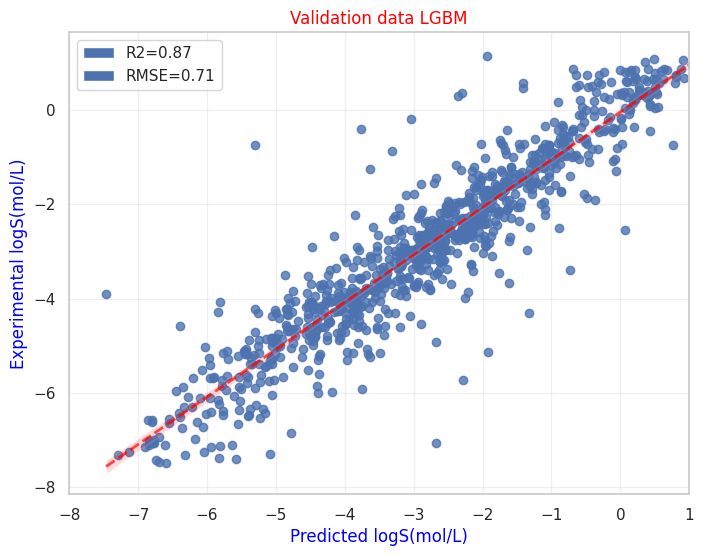

In [31]:
sn.set_theme(style="whitegrid")
plot_data(y_valid,y_preds,"Validation data LGBM")

In [32]:
#Calculate molecular descriptors for the test data or 98 compounds

Mol_descriptors_test , desc_names_test = RDkit_descriptors(data_dl["SMILES"])
data_dl_descriptors = pd.DataFrame(Mol_descriptors_test,columns=desc_names_test)

# Standard scaler - transform
x_scaled_test = custom_scaler.transform(data_dl_descriptors)

# Predict solubility of the test data
y_test_preds = model.predict(x_scaled_test)



Streaming output truncated to the last 5000 lines.
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
----------
Stacktrace:
----------
****

[08:24:40] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 40 in file /project/build/temp.linux-x86_64-cpython-310/rdkit/Code/GraphMol/Descriptors/Crippen.cpp
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
----------
Stacktrace:
----------
****

[08:24:40] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 40 in file /project/build/temp.linux-x86_64-cpython-310/rdkit/Code/GraphMol/Descriptors/Crippen.cpp
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
----------
Stacktrace:
----------
****

[08:24:40] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 40 in file /project/build/temp.linux-x86_64-cpy

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


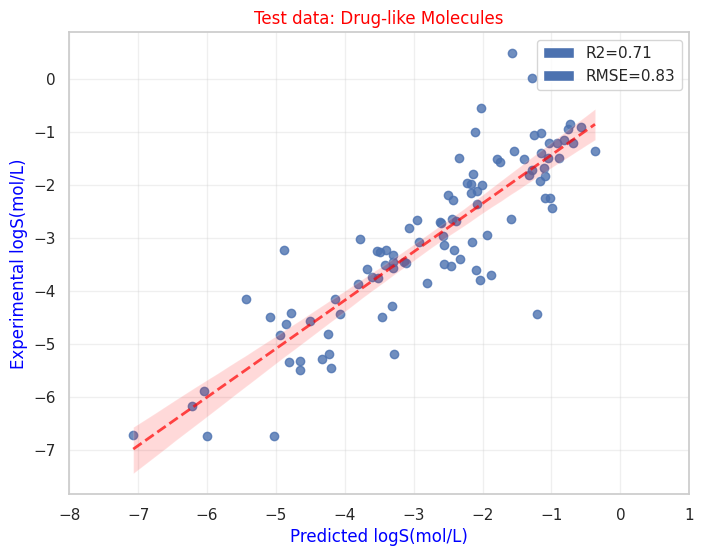

In [33]:
# Plotting testing set
sn.set_theme(style="whitegrid")
plot_data(data_dl["LogS exp (mol/L)"], y_test_preds,
           "Test data: Drug-like Molecules")

#7.2 Random Forrest



Let's test the Random Forest model with the following values:

. max depth: 26

. n estimator: 901

In [34]:
# Replace NaN values by the average
imputer = SimpleImputer(strategy='mean')

# Imput the misssing values in x_train_scaled
x_train_imputed = imputer.fit_transform(x_train_scaled)

# Model creation for RandomForestRegressor
modelRF = RandomForestRegressor(n_estimators=901,
                               max_depth=26,
                               random_state=42)

# Model training on the given data
modelRF.fit(x_train_imputed, y_train)

# Imput missing values in x_valid_scaled
x_valid_imputed = imputer.transform(x_valid_scaled)

# Prediction
y_preds_RF = modelRF.predict(x_valid_imputed)


In [35]:
# A plotting function
def plot_data_RF(actual, predicted, title):

# model performance using RMSE
    rmse = np.sqrt(mean_squared_error(actual, predicted))

# R^2 (coefficient of determination) :
    R2 =r2_score(actual, predicted)
    plt.figure(figsize=(8,6))

# Plot the figure
    sn.regplot(x=predicted , y=actual,line_kws={"lw":2,
                                                "ls":"--",
                                                "color":"red",
                                                "alpha":0.7})
    plt.title(title, color="red")
    plt.xlabel("Predicted logS(mol/L)",
               color="blue")
    plt.xlim(-8,1)
    plt.ylabel("Experimental logS(mol/L)",
               color ="blue")


    plt.grid(alpha=0.3)
    R2 = mpatches.Patch(label="R2={:04.2f}".format(R2))
    rmse = mpatches.Patch(label="RMSE={:04.2f}".format(rmse))
    plt.legend(handles=[R2, rmse])

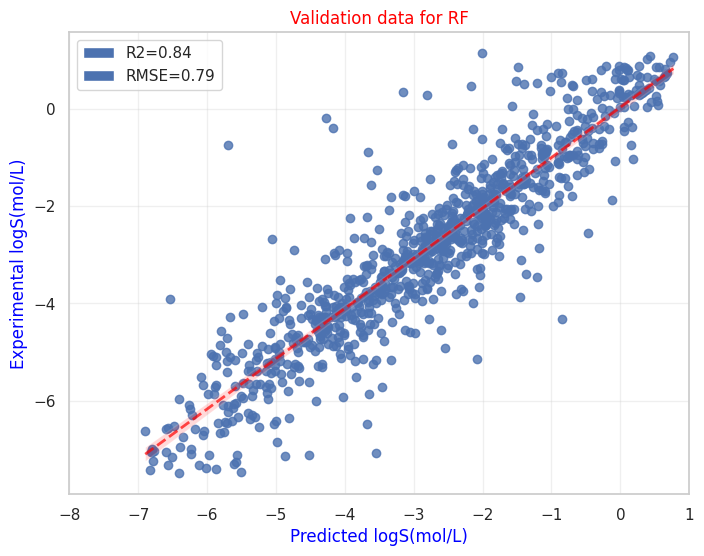

In [36]:
sn.set_theme(style="whitegrid")
plot_data_RF(y_valid,y_preds_RF,"Validation data for RF")

In [ ]:
from sklearn.impute import SimpleImputer

# Calculate molecular descriptors for the test data
Mol_descriptors_test, desc_names_test = RDkit_descriptors(data_dl["SMILES"])
data_dl_descriptors = pd.DataFrame(Mol_descriptors_test, columns=desc_names_test)

# Impute missing values in the test data
imputer = SimpleImputer(strategy='mean')
x_scaled_test_imputed = imputer.fit_transform(data_dl_descriptors)

# Check the number of features in the training data (assuming it's the same as the model's expected features)
num_train_features = x_train_scaled.shape[1]

# If the number of features in the test data does not match the number of features in the training data,
# adjust the test data accordingly
if x_scaled_test_imputed.shape[1] != num_train_features:
    if x_scaled_test_imputed.shape[1] < num_train_features:
        # Add dummy columns for missing features
        num_missing_features = num_train_features - x_scaled_test_imputed.shape[1]
        dummy_columns = np.zeros((x_scaled_test_imputed.shape[0], num_missing_features))
        x_scaled_test_adjusted = np.hstack((x_scaled_test_imputed, dummy_columns))
    elif x_scaled_test_imputed.shape[1] > num_train_features:
        # Remove excess features
        x_scaled_test_adjusted = x_scaled_test_imputed[:, :num_train_features]
else:
    x_scaled_test_adjusted = x_scaled_test_imputed

# Predict solubility of the adjusted test data
y_test_preds = modelRF.predict(x_scaled_test_adjusted)



Streaming output truncated to the last 5000 lines.
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
----------
Stacktrace:
----------
****

[21:34:00] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 40 in file /project/build/temp.linux-x86_64-cpython-310/rdkit/Code/GraphMol/Descriptors/Crippen.cpp
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
----------
Stacktrace:
----------
****

[21:34:00] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 40 in file /project/build/temp.linux-x86_64-cpython-310/rdkit/Code/GraphMol/Descriptors/Crippen.cpp
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
----------
Stacktrace:
----------
****

[21:34:00] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 40 in file /project/build/temp.linux-x86_64-cpy

In [60]:
from sklearn.impute import SimpleImputer

# Preprocess SMILES data to obtain molecular descriptors
Mol_descriptors_test, desc_names_test = RDkit_descriptors(data_dl["SMILES"])
data_dl_descriptors = pd.DataFrame(Mol_descriptors_test, columns=desc_names_test)

# Scale the descriptors using the same scaler used during training
x_scaled_test = custom_scaler.transform(data_dl_descriptors)

# Check for NaN values in the scaled test data
if np.isnan(x_scaled_test).any():
    # Impute NaN values in test data
    imputer = SimpleImputer(strategy='mean')
    x_scaled_test = imputer.fit_transform(x_scaled_test)

# Ensure the number of features matches the model's expectations
if x_scaled_test.shape[1] != modelRF.n_features_:
    raise ValueError(f"Number of features in test data ({x_scaled_test.shape[1]}) "
                     f"does not match the model's expectations ({modelRF.n_features_})")

# Predict solubility using the trained Random Forest model
y_test_preds_RF = modelRF.predict(x_scaled_test)




Streaming output truncated to the last 5000 lines.
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
----------
Stacktrace:
----------
****

 47%|████▋     | 46/98 [00:03<00:04, 10.60it/s][09:21:04] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 40 in file /project/build/temp.linux-x86_64-cpython-310/rdkit/Code/GraphMol/Descriptors/Crippen.cpp
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
----------
Stacktrace:
----------
****

[09:21:04] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 40 in file /project/build/temp.linux-x86_64-cpython-310/rdkit/Code/GraphMol/Descriptors/Crippen.cpp
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
----------
Stacktrace:
----------
****

[09:21:04] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 

AttributeError: 'RandomForestRegressor' object has no attribute 'n_features_'

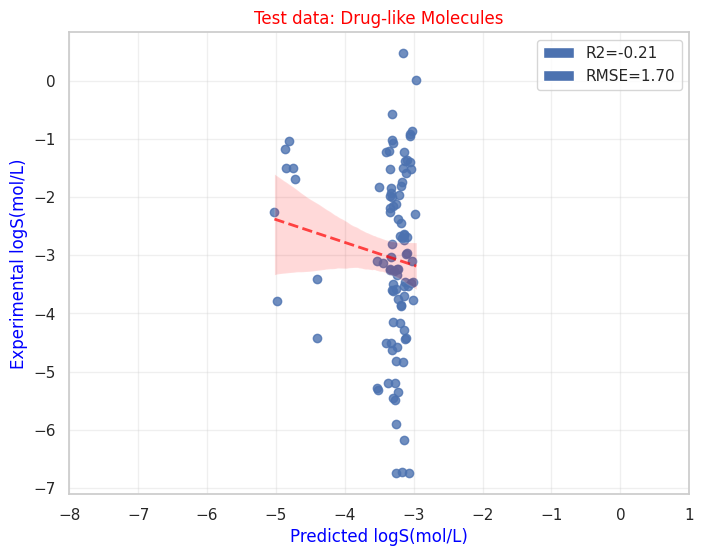

In [ ]:
# Plotting testing set
sn.set_theme(style="whitegrid")
plot_data_RF(data_dl["LogS exp (mol/L)"], y_test_preds,
           "Test data: Drug-like Molecules")

In [72]:
# Calculate molecular descriptors for the test data or 98 compounds
Mol_descriptors_test, desc_names_test = RDkit_descriptors(data_dl["SMILES"])
data_dl_descriptors = pd.DataFrame(Mol_descriptors_test, columns=desc_names_test)

# Standard scaler - transform
x_scaled_test = custom_scaler.transform(data_dl_descriptors)

# Convert scaled descriptors back to DataFrame
x_scaled_test_df = pd.DataFrame(x_scaled_test, columns=desc_names_test)

# Predict solubility of the test data
y_test_preds = modelRF.predict(x_scaled_test_df)


Streaming output truncated to the last 5000 lines.
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
----------
Stacktrace:
----------
****

[09:39:46] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 40 in file /project/build/temp.linux-x86_64-cpython-310/rdkit/Code/GraphMol/Descriptors/Crippen.cpp
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
----------
Stacktrace:
----------
****

[09:39:46] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 40 in file /project/build/temp.linux-x86_64-cpython-310/rdkit/Code/GraphMol/Descriptors/Crippen.cpp
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
----------
Stacktrace:
----------
****

[09:39:46] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 40 in file /project/build/temp.linux-x86_64-cpy

KeyError: 'SMILES'

#8. Saving of the trained model and standard scaler

In [ ]:
with open("model_WSP.pkl","wb") as f:
    pickle.dump(model,f)

with open("scaler_WSP.pkl","wb") as f:
    pickle.dump(custom_scaler,f)